# Neural Networks More Hidden Neurons: Predicting if customers will purchase based on browsing behavior v_2


In [1]:
# Demonstrating how additional neurons improve model performance on complex patterns

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(42)  # Set seed for reproducible results

# =============================================================================
# Enhanced Dataset with More Complex Patterns (Requires More Neurons)
# =============================================================================

class ComplexCustomerDataset(Dataset):  # More complex customer behavior dataset
    """Dataset with complex, multi-modal customer purchase patterns"""
    
    def __init__(self, num_samples=1000):  # Generate complex customer behavior data
        # Create browsing times from 0 to 120 minutes
        self.browsing_time = torch.linspace(0, 120, num_samples).unsqueeze(1)  # Evenly spaced browsing times
        
        # Create complex purchase pattern with multiple decision regions
        x = self.browsing_time.squeeze()  # Remove extra dimension for calculations
        
        # Complex decision function: multiple purchase "sweet spots"
        # High purchase probability for: 5-15 min, 25-35 min, 60-80 min browsing
        purchase_logits = torch.zeros_like(x)  # Initialize purchase probabilities
        
        # Sweet spot 1: Quick decision makers (5-15 minutes)
        mask1 = (x >= 5) & (x <= 15)  # Boolean mask for first sweet spot
        purchase_logits[mask1] = 2.0 + torch.sin(x[mask1] * 0.5)  # High probability with variation
        
        # Sweet spot 2: Research buyers (25-35 minutes) 
        mask2 = (x >= 25) & (x <= 35)  # Boolean mask for second sweet spot
        purchase_logits[mask2] = 1.5 + torch.cos(x[mask2] * 0.3)  # Moderate-high probability
        
        # Sweet spot 3: Thorough browsers (60-80 minutes)
        mask3 = (x >= 60) & (x <= 80)  # Boolean mask for third sweet spot
        purchase_logits[mask3] = 1.8 + torch.sin(x[mask3] * 0.2)  # High probability region
        
        # Add noise to make it more realistic and harder to classify
        noise = torch.randn(num_samples) * 0.3  # Random noise for realistic complexity
        purchase_logits += noise  # Add noise to purchase decisions
        
        # Convert to binary labels (0=no purchase, 1=purchase)
        self.purchased = (torch.sigmoid(purchase_logits) > 0.5).float().unsqueeze(1)  # Apply sigmoid and threshold
        
        self.len = num_samples  # Store dataset size
    
    def __getitem__(self, index):  # Get individual sample
        return self.browsing_time[index], self.purchased[index]  # Return (feature, label) pair
    
    def __len__(self):  # Get dataset size
        return self.len  # Return total samples


In [2]:
# =============================================================================
# Neural Network with Flexible Hidden Layer Size (nn.Module)
# =============================================================================

class FlexibleCustomerNet(nn.Module):  # Flexible neural network with configurable neurons
    """Neural network with adjustable hidden layer size for comparison"""
    
    def __init__(self, input_size, hidden_size, output_size):  # Constructor with flexible hidden size
        super(FlexibleCustomerNet, self).__init__()  # Call parent constructor
        
        # Hidden layer with variable number of neurons
        self.hidden = nn.Linear(input_size, hidden_size)  # Input to hidden transformation
        
        # Output layer (always 1 neuron for binary classification)
        self.output = nn.Linear(hidden_size, output_size)  # Hidden to output transformation
    
    def forward(self, x):  # Forward pass through network
        # Apply linear transformation and ReLU activation to hidden layer
        hidden_output = torch.relu(self.hidden(x))  # ReLU activation prevents vanishing gradients
        
        # Apply final transformation and sigmoid for probability
        purchase_probability = torch.sigmoid(self.output(hidden_output))  # Sigmoid maps to [0,1]
        
        return purchase_probability  # Return purchase probability


In [3]:
# =============================================================================
# Neural Network using nn.Sequential (Alternative Implementation)
# =============================================================================

def create_sequential_model(input_size, hidden_size, output_size):  # Function to create Sequential model
    """Create neural network using nn.Sequential for comparison"""
    
    model = nn.Sequential(  # Sequential container chains operations
        nn.Linear(input_size, hidden_size),  # Input to hidden linear layer
        nn.ReLU(),  # ReLU activation function
        nn.Linear(hidden_size, output_size),  # Hidden to output linear layer
        nn.Sigmoid()  # Final sigmoid activation
    )
    
    return model  # Return complete sequential model


In [4]:
# =============================================================================
# Training Function with Loss Tracking
# =============================================================================

def train_model_with_tracking(model, train_loader, criterion, optimizer, num_epochs):  # Enhanced training function
    """Train model and track performance metrics"""
    
    loss_history = []  # Track loss over epochs
    accuracy_history = []  # Track accuracy over epochs
    
    for epoch in range(num_epochs):  # Loop through training epochs
        epoch_loss = 0.0  # Accumulate loss for current epoch
        correct_predictions = 0  # Count correct predictions
        total_samples = 0  # Count total samples
        
        model.train()  # Set model to training mode
        
        for batch_x, batch_y in train_loader:  # Process each batch
            optimizer.zero_grad()  # Clear gradients from previous step
            
            # Forward pass: get model predictions
            predictions = model(batch_x)  # Model predictions for current batch
            
            # Calculate loss
            loss = criterion(predictions, batch_y)  # Binary cross-entropy loss
            
            # Backward pass: compute gradients
            loss.backward()  # Backpropagate error through network
            
            # Update parameters
            optimizer.step()  # Apply computed gradients
            
            # Track metrics
            epoch_loss += loss.item()  # Accumulate loss
            predicted_classes = (predictions > 0.5).float()  # Convert probabilities to binary
            correct_predictions += (predicted_classes == batch_y).sum().item()  # Count correct predictions
            total_samples += batch_y.size(0)  # Count total samples
        
        # Calculate average metrics for epoch
        avg_loss = epoch_loss / len(train_loader)  # Average loss per batch
        accuracy = correct_predictions / total_samples  # Accuracy for epoch
        
        loss_history.append(avg_loss)  # Store loss
        accuracy_history.append(accuracy)  # Store accuracy
        
        # Print progress every 25 epochs
        if (epoch + 1) % 25 == 0:  # Progress reporting
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')
    
    return loss_history, accuracy_history  # Return training metrics


=== Creating Complex Customer Purchase Dataset ===


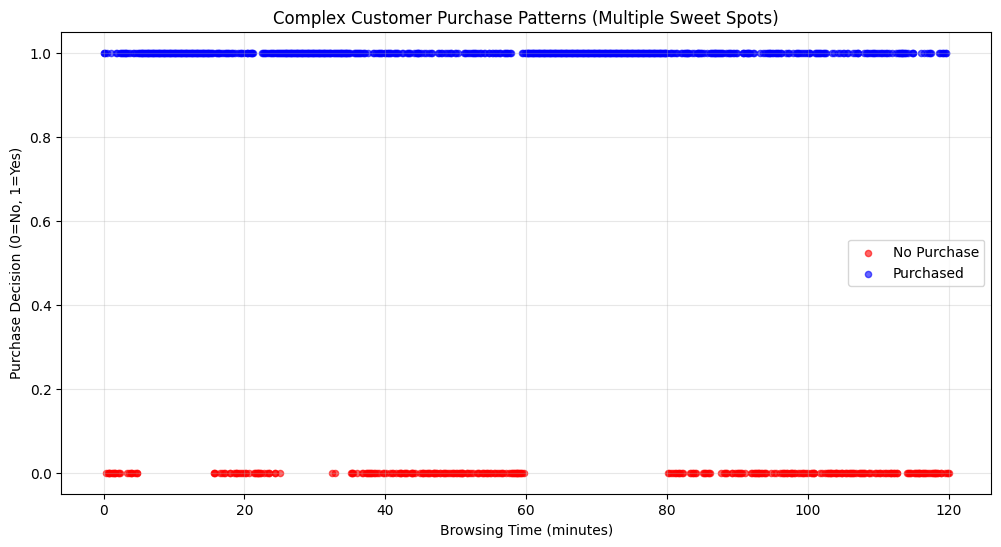

In [5]:
# =============================================================================
# Create Complex Dataset and Compare Models with Different Neuron Counts
# =============================================================================

print("=== Creating Complex Customer Purchase Dataset ===")
complex_dataset = ComplexCustomerDataset(num_samples=1000)  # Generate complex dataset
train_loader = DataLoader(complex_dataset, batch_size=32, shuffle=True)  # Create data loader

# Visualize complex dataset
def plot_complex_data(dataset):  # Function to visualize complex patterns
    """Plot the complex customer behavior patterns"""
    
    browsing_times = dataset.browsing_time.numpy().flatten()  # Get browsing times
    purchases = dataset.purchased.numpy().flatten()  # Get purchase decisions
    
    plt.figure(figsize=(12, 6))  # Create figure
    
    # Plot non-purchasers (red)
    no_purchase_mask = purchases == 0  # Mask for non-purchasers
    plt.scatter(browsing_times[no_purchase_mask], purchases[no_purchase_mask], 
               c='red', alpha=0.6, label='No Purchase', s=20)  # Red dots
    
    # Plot purchasers (blue)
    purchase_mask = purchases == 1  # Mask for purchasers
    plt.scatter(browsing_times[purchase_mask], purchases[purchase_mask], 
               c='blue', alpha=0.6, label='Purchased', s=20)  # Blue dots
    
    plt.xlabel('Browsing Time (minutes)')  # X-axis label
    plt.ylabel('Purchase Decision (0=No, 1=Yes)')  # Y-axis label
    plt.title('Complex Customer Purchase Patterns (Multiple Sweet Spots)')  # Title
    plt.legend()  # Show legend
    plt.grid(True, alpha=0.3)  # Add grid
    plt.show()  # Display plot

plot_complex_data(complex_dataset)  # Visualize the complex data


In [6]:
# =============================================================================
# Compare Models with Different Numbers of Hidden Neurons
# =============================================================================

print("\n=== Comparing Models with Different Hidden Layer Sizes ===")

# Model configurations to compare
model_configs = [  # List of different neuron counts to test
    {"name": "Small (2 neurons)", "hidden_size": 2},  # Simple model
    {"name": "Medium (6 neurons)", "hidden_size": 6},  # Medium complexity
    {"name": "Large (12 neurons)", "hidden_size": 12}  # High complexity
]

input_size = 1  # Single input feature (browsing time)
output_size = 1  # Single output (purchase probability)
num_epochs = 100  # Training epochs
learning_rate = 0.01  # Learning rate for optimizer

results = {}  # Store results for each model

for config in model_configs:  # Test each model configuration
    print(f"\n--- Training {config['name']} ---")
    
    # Create model using nn.Module approach
    model = FlexibleCustomerNet(input_size, config['hidden_size'], output_size)  # Create model
    
    # Define loss and optimizer
    criterion = nn.BCELoss()  # Binary cross-entropy loss
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Adam optimizer
    
    # Train the model
    loss_history, accuracy_history = train_model_with_tracking(  # Train and track metrics
        model, train_loader, criterion, optimizer, num_epochs
    )
    
    # Store results
    results[config['name']] = {  # Save results for comparison
        'model': model,
        'loss_history': loss_history,
        'accuracy_history': accuracy_history,
        'final_accuracy': accuracy_history[-1]
    }
    
    print(f"Final accuracy: {accuracy_history[-1]:.4f}")  # Print final performance



=== Comparing Models with Different Hidden Layer Sizes ===

--- Training Small (2 neurons) ---
Epoch [25/100], Loss: 0.6334, Accuracy: 0.6610
Epoch [50/100], Loss: 0.6290, Accuracy: 0.6610
Epoch [75/100], Loss: 0.6358, Accuracy: 0.6610
Epoch [100/100], Loss: 0.6335, Accuracy: 0.6610
Final accuracy: 0.6610

--- Training Medium (6 neurons) ---
Epoch [25/100], Loss: 0.6114, Accuracy: 0.6700
Epoch [50/100], Loss: 0.6147, Accuracy: 0.6750
Epoch [75/100], Loss: 0.6233, Accuracy: 0.6670
Epoch [100/100], Loss: 0.6072, Accuracy: 0.6730
Final accuracy: 0.6730

--- Training Large (12 neurons) ---
Epoch [25/100], Loss: 0.6496, Accuracy: 0.6220
Epoch [50/100], Loss: 0.6300, Accuracy: 0.6560
Epoch [75/100], Loss: 0.6828, Accuracy: 0.6220
Epoch [100/100], Loss: 0.6212, Accuracy: 0.6720
Final accuracy: 0.6720


In [7]:
# =============================================================================
# Create Enhanced Model using nn.Sequential (7 neurons as mentioned in transcript)
# =============================================================================

print(f"\n=== Creating Enhanced Sequential Model (7 neurons) ===")

# Create sequential model with 7 neurons (as mentioned in transcript)
sequential_model = create_sequential_model(input_size, 7, output_size)  # 7-neuron sequential model
print(f"Sequential model architecture: {sequential_model}")  # Print model structure

# Train sequential model
criterion = nn.BCELoss()  # Binary cross-entropy loss
optimizer = torch.optim.Adam(sequential_model.parameters(), lr=learning_rate)  # Adam optimizer

sequential_loss, sequential_accuracy = train_model_with_tracking(  # Train sequential model
    sequential_model, train_loader, criterion, optimizer, num_epochs
)

print(f"Sequential model final accuracy: {sequential_accuracy[-1]:.4f}")  # Print final performance



=== Creating Enhanced Sequential Model (7 neurons) ===
Sequential model architecture: Sequential(
  (0): Linear(in_features=1, out_features=7, bias=True)
  (1): ReLU()
  (2): Linear(in_features=7, out_features=1, bias=True)
  (3): Sigmoid()
)
Epoch [25/100], Loss: 0.6338, Accuracy: 0.6650
Epoch [50/100], Loss: 0.6317, Accuracy: 0.6680
Epoch [75/100], Loss: 0.6339, Accuracy: 0.6670
Epoch [100/100], Loss: 0.6295, Accuracy: 0.6680
Sequential model final accuracy: 0.6680


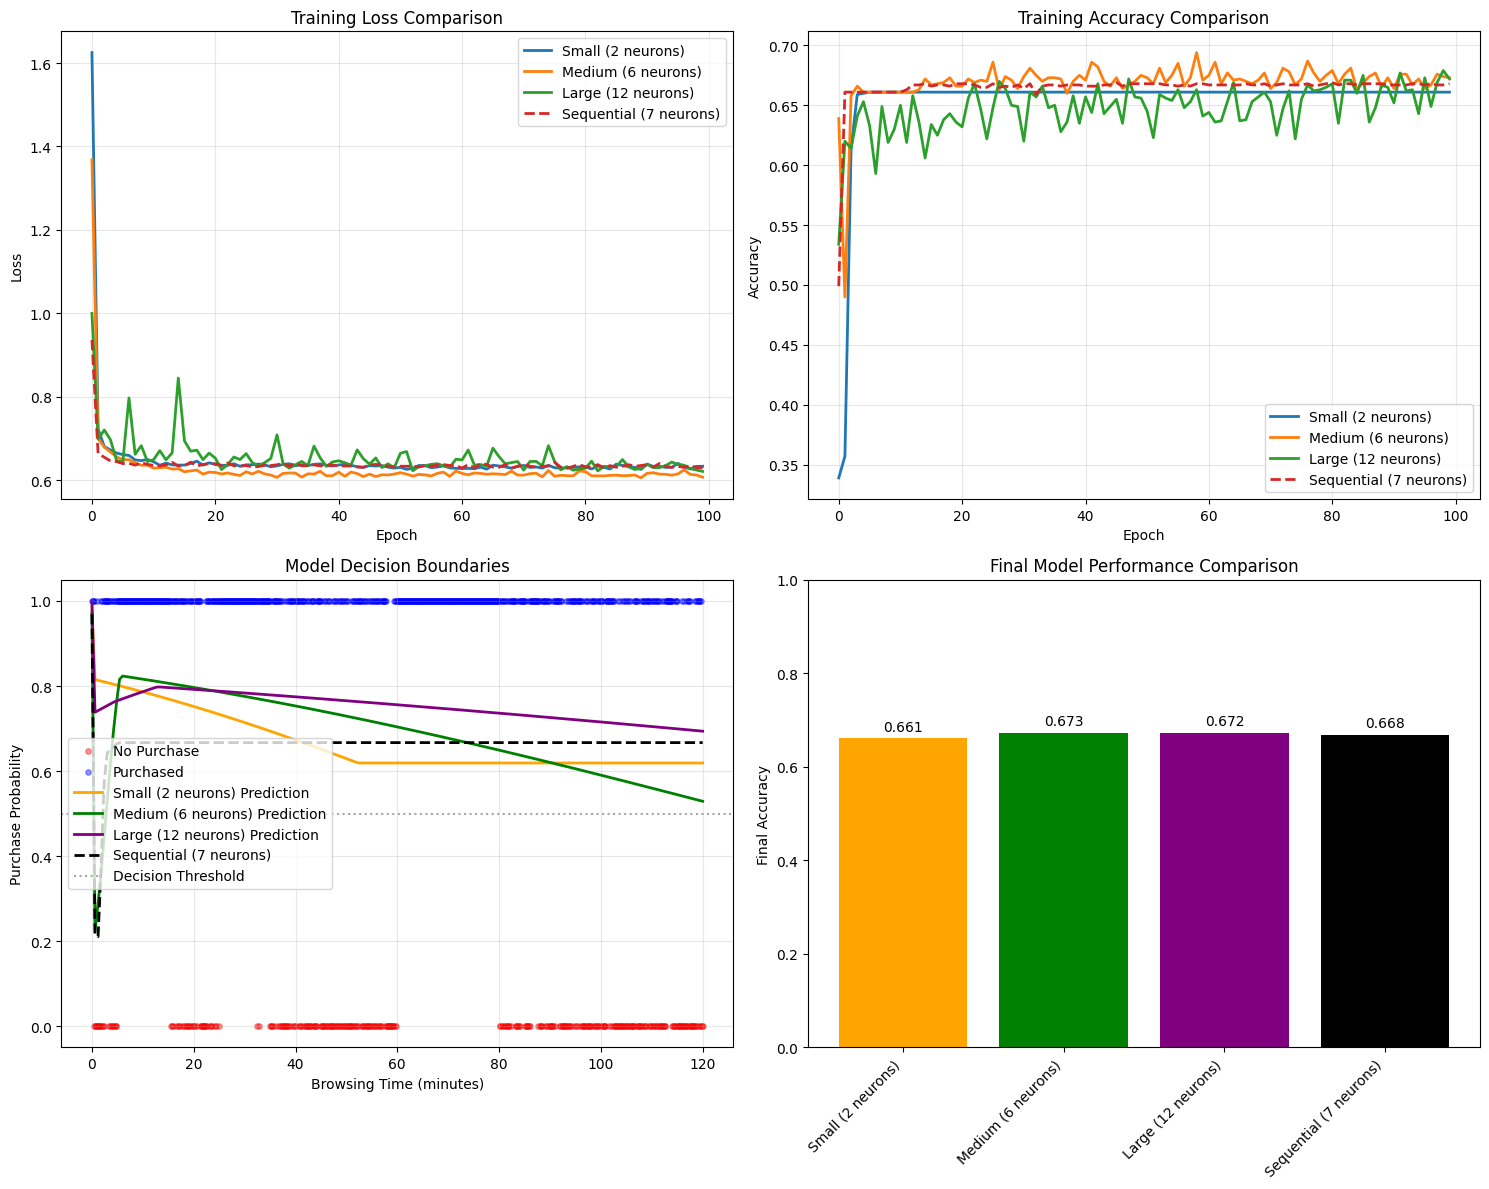

In [10]:
# =============================================================================
# Visualize Model Comparisons and Decision Boundaries
# =============================================================================

def plot_model_comparisons(results, complex_dataset, sequential_model=None):  # Comprehensive comparison visualization
    """Plot training progress and decision boundaries for all models"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))  # Create 2x2 subplot grid
    
    # Plot 1: Training Loss Comparison
    ax1 = axes[0, 0]  # Top-left subplot
    for name, result in results.items():  # Plot loss for each model
        ax1.plot(result['loss_history'], label=name, linewidth=2)  # Loss curves
    if sequential_model:  # Add sequential model if provided
        ax1.plot(sequential_loss, label='Sequential (7 neurons)', linewidth=2, linestyle='--')  # Dashed line
    ax1.set_xlabel('Epoch')  # X-axis label
    ax1.set_ylabel('Loss')  # Y-axis label
    ax1.set_title('Training Loss Comparison')  # Subplot title
    ax1.legend()  # Show legend
    ax1.grid(True, alpha=0.3)  # Add grid
    
    # Plot 2: Accuracy Comparison
    ax2 = axes[0, 1]  # Top-right subplot
    for name, result in results.items():  # Plot accuracy for each model
        ax2.plot(result['accuracy_history'], label=name, linewidth=2)  # Accuracy curves
    if sequential_model:  # Add sequential model if provided
        ax2.plot(sequential_accuracy, label='Sequential (7 neurons)', linewidth=2, linestyle='--')  # Dashed line
    ax2.set_xlabel('Epoch')  # X-axis label
    ax2.set_ylabel('Accuracy')  # Y-axis label
    ax2.set_title('Training Accuracy Comparison')  # Subplot title
    ax2.legend()  # Show legend
    ax2.grid(True, alpha=0.3)  # Add grid
    
    # Plot 3: Decision Boundaries Comparison
    ax3 = axes[1, 0]  # Bottom-left subplot
    
    # Get data for plotting
    browsing_times = complex_dataset.browsing_time.numpy().flatten()  # Browsing times
    purchases = complex_dataset.purchased.numpy().flatten()  # Purchase decisions
    
    # Plot actual data points
    no_purchase_mask = purchases == 0  # Non-purchaser mask
    purchase_mask = purchases == 1  # Purchaser mask
    
    ax3.scatter(browsing_times[no_purchase_mask], purchases[no_purchase_mask], 
               c='red', alpha=0.4, label='No Purchase', s=15)  # Red dots
    ax3.scatter(browsing_times[purchase_mask], purchases[purchase_mask], 
               c='blue', alpha=0.4, label='Purchased', s=15)  # Blue dots
    
    # Create smooth prediction curves
    test_times = torch.linspace(0, 120, 200).unsqueeze(1)  # Test range
    
    colors = ['orange', 'green', 'purple']  # Colors for different models
    for i, (name, result) in enumerate(results.items()):  # Plot each model's predictions
        with torch.no_grad():  # No gradients needed
            predictions = result['model'](test_times).numpy().flatten()  # Get predictions
        ax3.plot(test_times.numpy().flatten(), predictions, 
                color=colors[i], linewidth=2, label=f'{name} Prediction')  # Plot prediction curve
    
    # Add sequential model prediction
    if sequential_model:  # Plot sequential model if provided
        with torch.no_grad():  # No gradients needed
            seq_predictions = sequential_model(test_times).numpy().flatten()  # Sequential predictions
        ax3.plot(test_times.numpy().flatten(), seq_predictions, 
                color='black', linewidth=2, linestyle='--', label='Sequential (7 neurons)')  # Dashed line
    
    ax3.axhline(y=0.5, color='gray', linestyle=':', alpha=0.7, label='Decision Threshold')  # Decision threshold
    ax3.set_xlabel('Browsing Time (minutes)')  # X-axis label
    ax3.set_ylabel('Purchase Probability')  # Y-axis label
    ax3.set_title('Model Decision Boundaries')  # Subplot title
    ax3.legend()  # Show legend
    ax3.grid(True, alpha=0.3)  # Add grid
    
    # Plot 4: Final Accuracy Comparison Bar Chart
    ax4 = axes[1, 1]  # Bottom-right subplot
    model_names = list(results.keys())  # Get model names
    final_accuracies = [results[name]['final_accuracy'] for name in model_names]  # Get final accuracies
    
    if sequential_model:  # Add sequential model
        model_names.append('Sequential (7 neurons)')  # Add name
        final_accuracies.append(sequential_accuracy[-1])  # Add accuracy
    
    bars = ax4.bar(model_names, final_accuracies, color=['orange', 'green', 'purple', 'black'])  # Bar chart
    ax4.set_ylabel('Final Accuracy')  # Y-axis label
    ax4.set_title('Final Model Performance Comparison')  # Subplot title
    ax4.set_ylim(0, 1)  # Set y-axis limits
    
    # Add value labels on bars
    for bar, accuracy in zip(bars, final_accuracies):  # Add accuracy labels
        height = bar.get_height()  # Get bar height
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,  # Position text
                f'{accuracy:.3f}', ha='center', va='bottom')  # Format text
    
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
    plt.tight_layout()  # Adjust spacing
    plt.show()  # Display plot

# Generate comprehensive comparison
plot_model_comparisons(results, complex_dataset, sequential_model)  # Plot all comparisons


In [9]:
# =============================================================================
# Summary and Analysis
# =============================================================================

print(f"\n=== Model Performance Summary ===")
print(f"Dataset complexity: Multiple purchase 'sweet spots' at different browsing times")
print(f"Training samples: {len(complex_dataset)}")
print(f"Training epochs: {num_epochs}")

print(f"\nFinal Accuracy Results:")
for name, result in results.items():  # Print results for each model
    print(f"  {name}: {result['final_accuracy']:.4f} ({result['final_accuracy']*100:.2f}%)")

print(f"  Sequential (7 neurons): {sequential_accuracy[-1]:.4f} ({sequential_accuracy[-1]*100:.2f}%)")

# Demonstrate why more neurons help
print(f"\n=== Why More Neurons Improve Performance ===")
print(f"• Small model (2 neurons): Limited capacity to capture complex patterns")
print(f"• Medium model (6 neurons): Better flexibility for multiple decision regions") 
print(f"• Large model (12 neurons): High capacity but may overfit small datasets")
print(f"• Sequential model (7 neurons): Good balance of complexity and performance")

print(f"\nKey Insight: More neurons provide greater model flexibility to approximate")
print(f"complex decision functions, just like combining multiple sigmoid functions")
print(f"to create the desired classification boundary shape.")


=== Model Performance Summary ===
Dataset complexity: Multiple purchase 'sweet spots' at different browsing times
Training samples: 1000
Training epochs: 100

Final Accuracy Results:
  Small (2 neurons): 0.6610 (66.10%)
  Medium (6 neurons): 0.6730 (67.30%)
  Large (12 neurons): 0.6720 (67.20%)
  Sequential (7 neurons): 0.6680 (66.80%)

=== Why More Neurons Improve Performance ===
• Small model (2 neurons): Limited capacity to capture complex patterns
• Medium model (6 neurons): Better flexibility for multiple decision regions
• Large model (12 neurons): High capacity but may overfit small datasets
• Sequential model (7 neurons): Good balance of complexity and performance

Key Insight: More neurons provide greater model flexibility to approximate
complex decision functions, just like combining multiple sigmoid functions
to create the desired classification boundary shape.


# Breakdown of what changed from v_1

# Original Simple Model (Few Neurons)

### Original model with fewer neurons
``` python
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.hidden = nn.Linear(1, 2)    # ← Only 2 neurons in hidden layer
        self.output = nn.Linear(2, 1)    # ← Input size matches hidden neurons
    
    def forward(self, x):
        hidden_output = torch.relu(self.hidden(x))
        purchase_probability = torch.sigmoid(self.output(hidden_output))
        return purchase_probability
```
### Create simple model
``` python
simple_model = SimpleNet()  # 1 → 2 → 1 architecture
```

# Enhanced Model (More Neurons)

### Enhanced model with more neurons  
```python
class EnhancedNet(nn.Module):
    def __init__(self):
        super(EnhancedNet, self).__init__()
        self.hidden = nn.Linear(1, 8)    # ← Changed: 2 neurons → 8 neurons
        self.output = nn.Linear(8, 1)    # ← Changed: input size 2 → 8
    
    def forward(self, x):
        hidden_output = torch.relu(self.hidden(x))    # Same activation
        purchase_probability = torch.sigmoid(self.output(hidden_output))
        return purchase_probability
```
### Create enhanced model

```python
enhanced_model = EnhancedNet()  # 1 → 8 → 1 architecture
```